In [5]:
import pandas as pd
import scipy.stats
import yfinance as yf
import numpy as np
import pandas_datareader.data as web
from Cython.Shadow import volatile
from IPython.core.pylabtools import figsize

# Import Data, Simple and log returns
df = yf.download('AAPL',
                 start= '2010-01-01',
                 end = '2020-01-01',
                 progress=False,
                 auto_adjust=True)
df.columns = df.columns.droplevel('Ticker')
df = df.loc[:, ['Close']]
df.rename(columns = {'Close': 'adj_close'}, inplace= True)

df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close / df.adj_close.shift(1))

In [6]:
# Create
df_all_dates = pd.DataFrame(index = pd.date_range(start ='2009-12-31',
                                                  end = '2020-12-31'))
df = df_all_dates.join(df[['adj_close']], how = 'left') \
    .fillna(method = 'ffill') \
    .asfreq('M')

#Calculate cpi
df_cpi = web.DataReader('CPIAUCSL', 'fred', start = '2009-12-31', end = '2020-12-31')
df_cpi.rename(columns = {'CPIAUCSL': 'cpi'}, inplace = True)
df_cpi.index = df_cpi.index.to_period('M').to_timestamp('M')

df_merged = df.join(df_cpi, how = 'left')

# Calculate simple rets and inf rates

df_merged['simple_rtn'] = df_merged.adj_close.pct_change()
df_merged['inflation_rate'] = df_merged.cpi.pct_change()
df_merged['real_rtn'] =(1+ df_merged.simple_rtn) / (1 + df_merged.inflation_rate) - 1


d

[*********************100%***********************]  1 of 1 completed


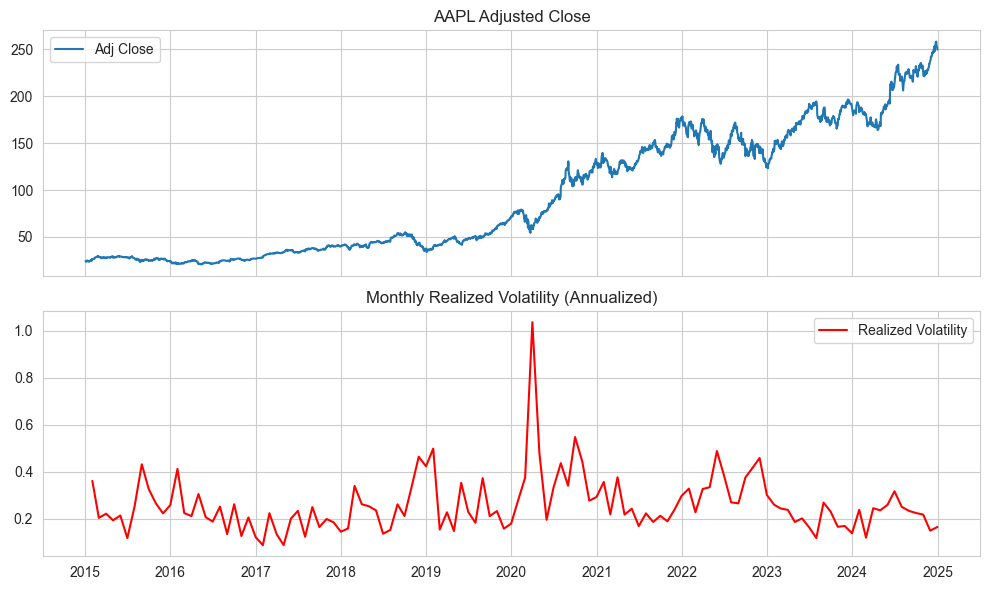

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download and prepare data
df = yf.download('AAPL', start='2015-01-01', end='2025-01-01', auto_adjust=True)
df['log_rtn'] = np.log(df['Close'] / df['Close'].shift(1))

# Define realized volatility function
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

# Realized monthly volatility (annualized)
df_rv = df['log_rtn'].groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv *= np.sqrt(12)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(df['Close'], label='Adj Close')
ax[0].set_title('AAPL Adjusted Close')
ax[0].legend()

ax[1].plot(df_rv, label='Realized Volatility', color='red')
ax[1].set_title('Monthly Realized Volatility (Annualized)')
ax[1].legend()

plt.tight_layout()
plt.show()


Visualizing time series


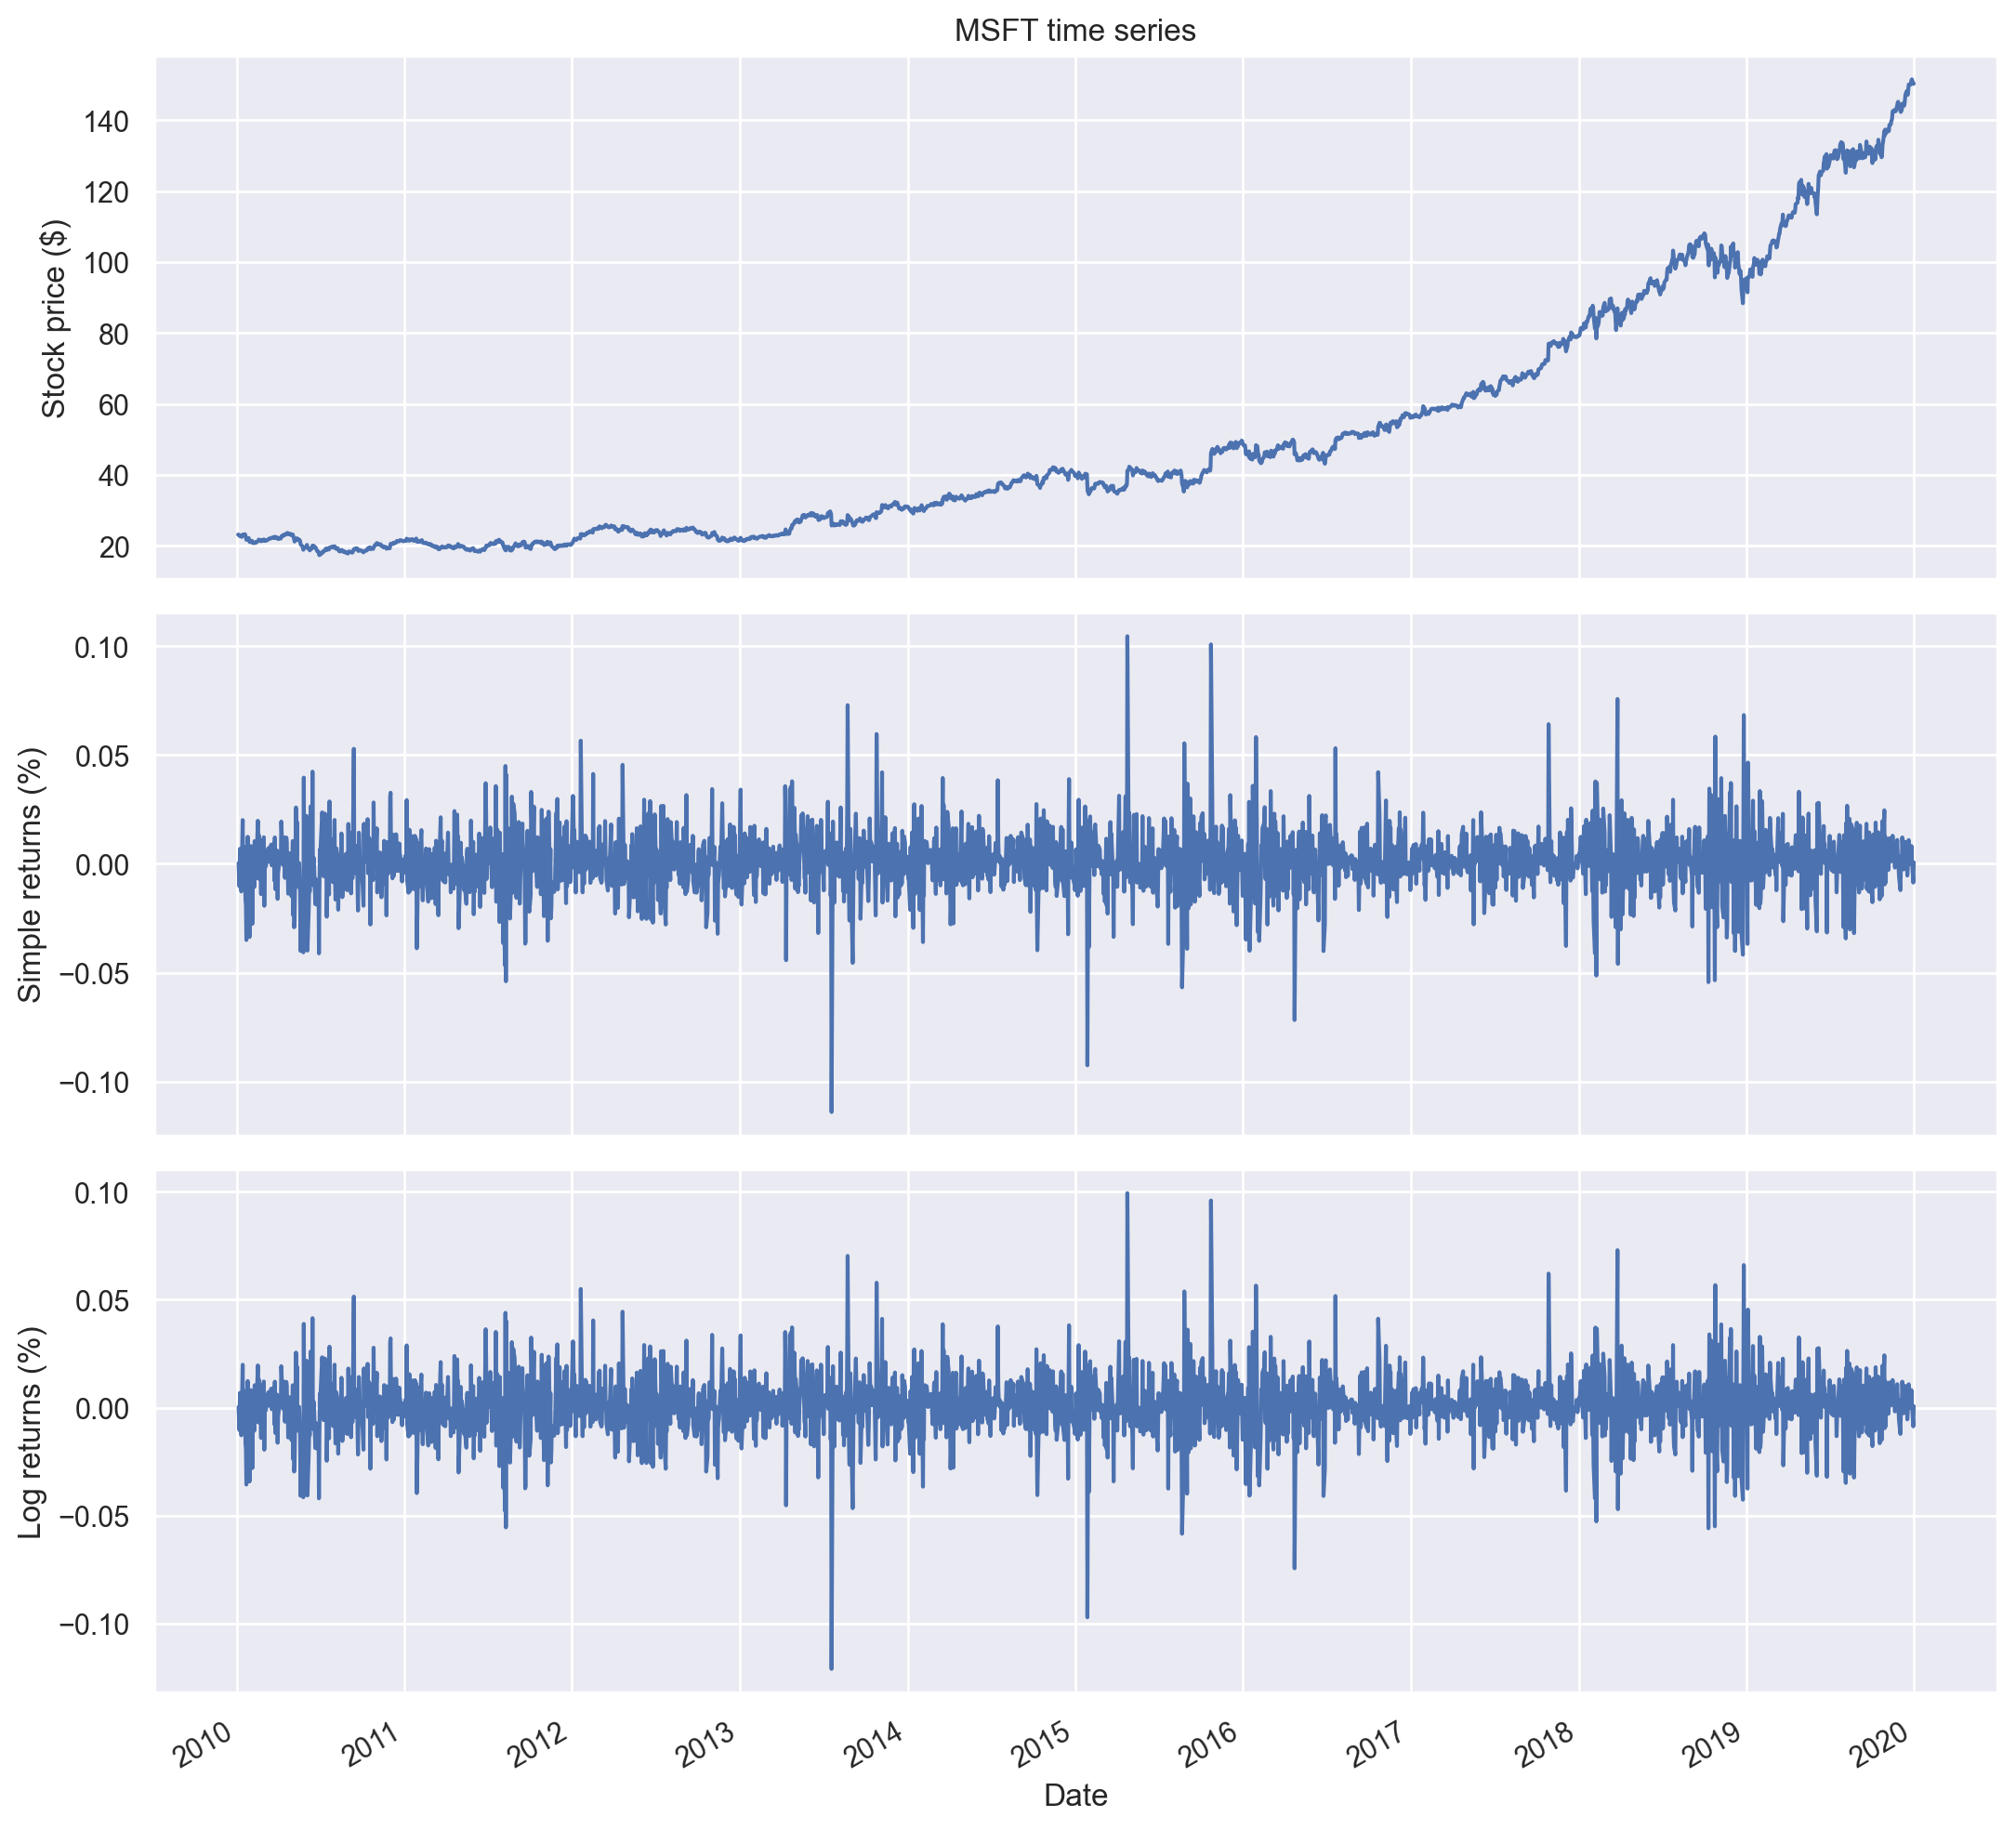

In [22]:
import seaborn as sns
sns.set_theme(style='darkgrid')
df = yf.download('MSFT',
                 start= '2010-01-01',
                 end = '2020-01-01',
                 progress=False,
                 auto_adjust=True)
df.dropna(inplace = True)
df.columns = df.columns.droplevel('Ticker')
df = df.loc[:, ['Close']]
df.rename(columns = {'Close': 'adj_close'}, inplace= True)

df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close / df.adj_close.shift(1))
# Start
fig, ax = plt.subplots(3, 1, figsize = (11, 10), sharex = True)
df.adj_close.plot(ax = ax[0])
ax[0].set(title ="MSFT time series", ylabel = 'Stock price ($)')

df.simple_rtn.plot(ax = ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

df.log_rtn.plot(ax = ax[2])
ax[2].set(ylabel = "Log returns (%)")

plt.tight_layout()

In [23]:
# Plotly
import cufflinks as cf
import seaborn as sns
sns.set_theme(style='darkgrid')
from plotly.offline import iplot, init_notebook_mode

# Set config once
#cf.set_config_file(world_readable = True, theme ='pearl', offline = True)

init_notebook_mode()
layout = dict(
    title = 'MSFT time series',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'Value'),
    height = 800,
    width = 1200
)
df.iplot(subplots = True, shape = (3, 1), shared_xaxes = True,
         layout =layout)

In [24]:
%config InlineBackend.figure_format = 'retina'

Handling outliers

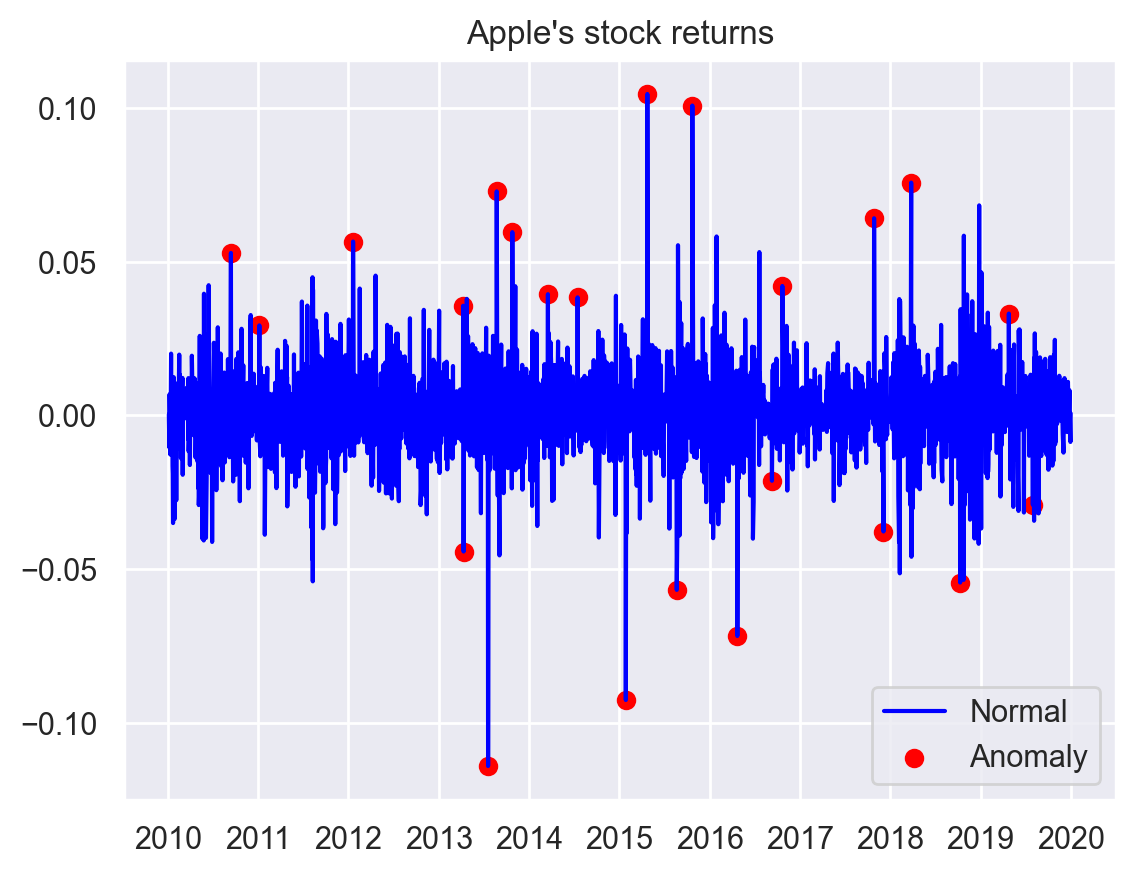

In [25]:
df_rolling = df[['simple_rtn']].rolling(window = 21).agg(['mean', 'std'])

df_rolling.columns = df_rolling.columns.droplevel()

df_outliers = df.join(df_rolling)

def identify_outliers(row, n_sigmas = 3):
    x =row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0
df_outliers['outlier'] = df_outliers.apply(identify_outliers,
                                           axis =1 )
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]

fig, ax = plt.subplots()
ax.plot(df_outliers.index, df_outliers.simple_rtn, color = 'blue', label = "Normal")
ax.scatter(outliers.index, outliers.simple_rtn, color = 'red', label = "Anomaly")
ax.set_title("Apple's stock returns")
ax.legend(loc = 'lower right')

[*********************100%***********************]  1 of 1 completed


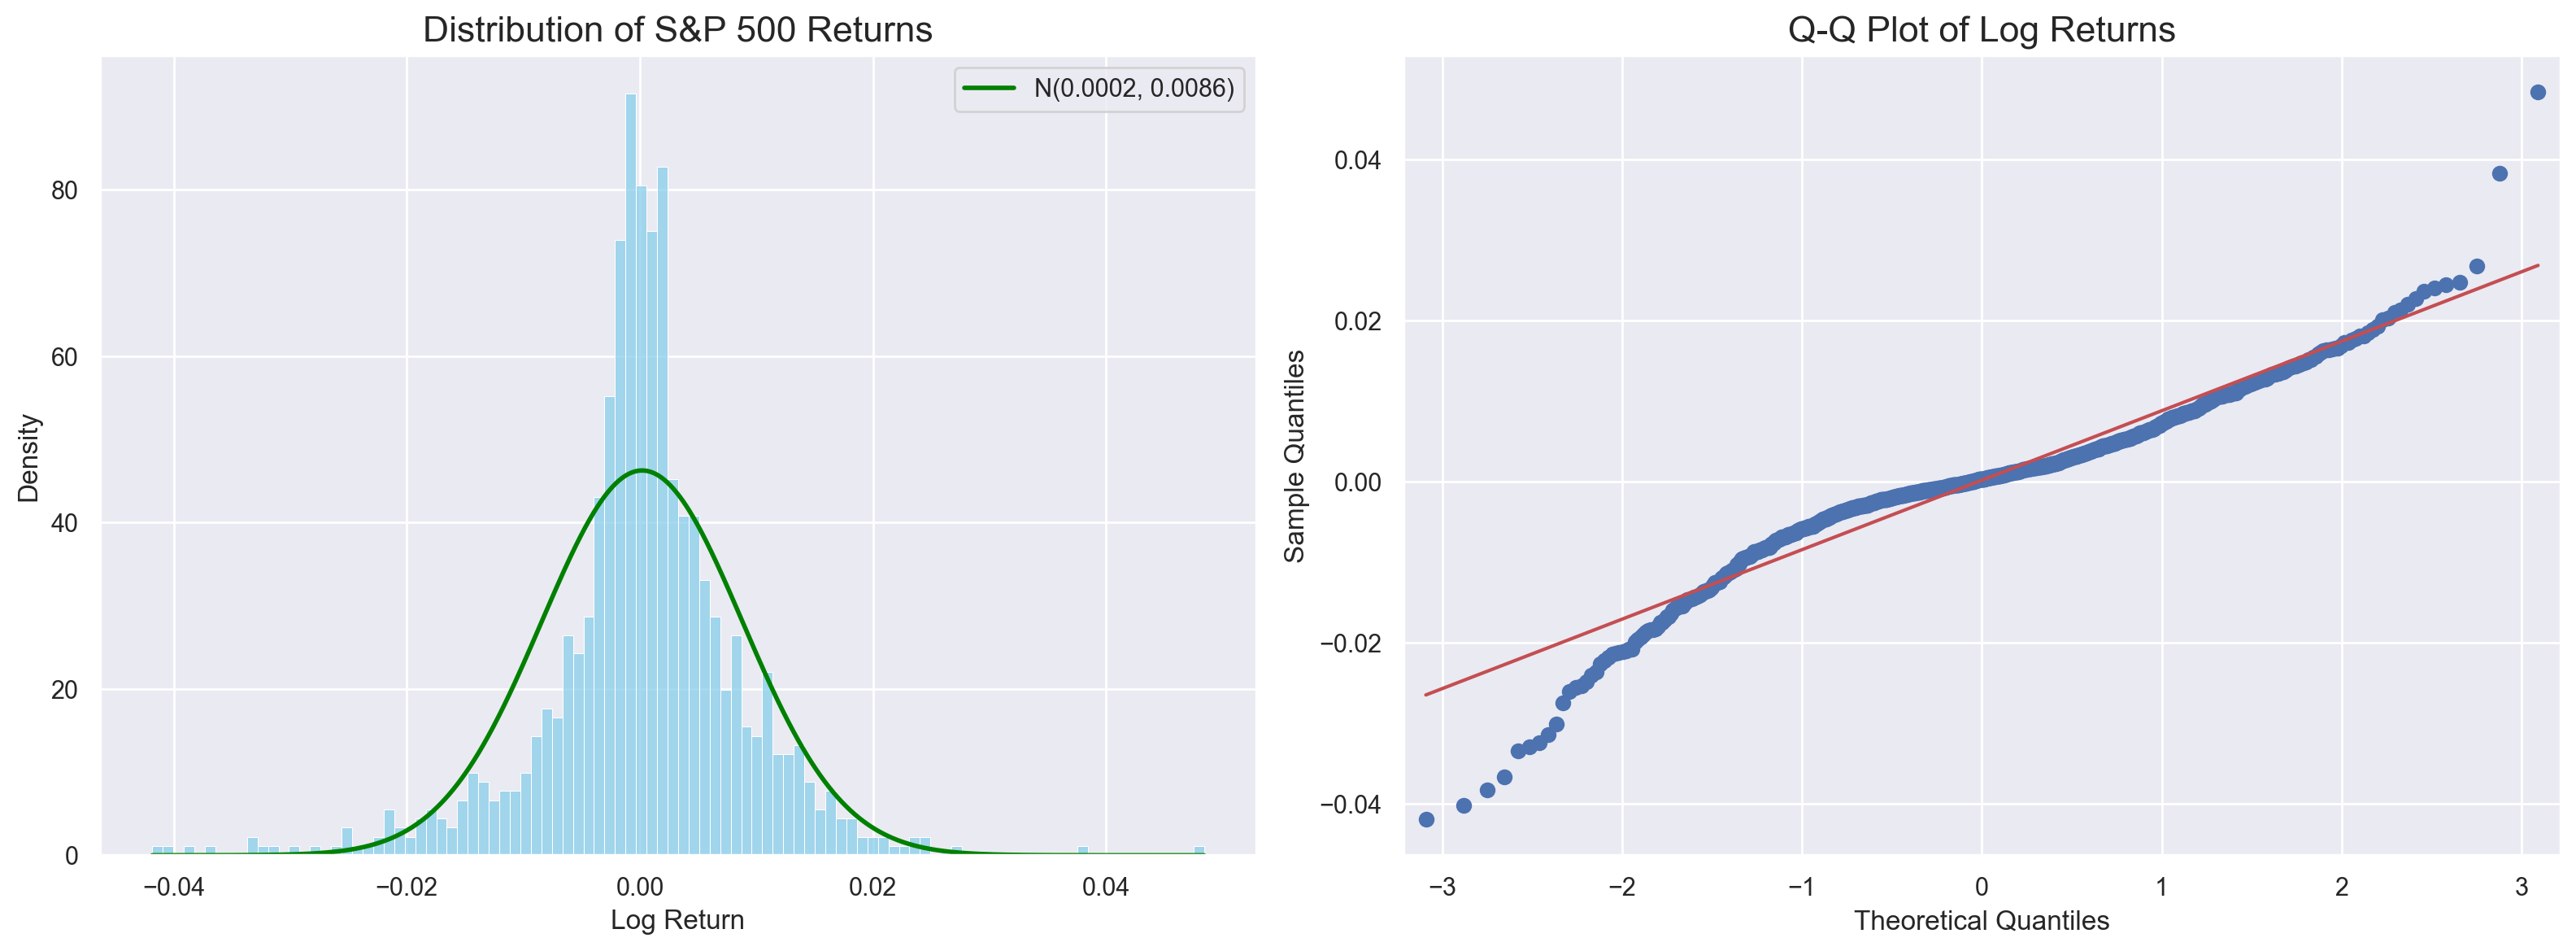

In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Download S&P 500 data
symbol = "^GSPC"
data = yf.download(symbol, start="2015-01-01", end="2018-12-31", auto_adjust=True)
data = data[['Close']].rename(columns={'Close': 'price'})
data['log_rtn'] = np.log(data['price'] / data['price'].shift(1))
data.dropna(inplace=True)

# Normal distribution line
r_range = np.linspace(data['log_rtn'].min(), data['log_rtn'].max(), num=1000)
mu = data['log_rtn'].mean()
sigma = data['log_rtn'].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

# Plot histogram + normal PDF + QQ-plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(data['log_rtn'], bins=100, stat="density", ax=ax[0], color="skyblue")
ax[0].plot(r_range, norm_pdf, color='green', lw=2, label=f'N({mu:.4f}, {sigma:.4f})')
ax[0].set_title('Distribution of S&P 500 Returns', fontsize=16)
ax[0].set_xlabel('Log Return')
ax[0].legend()

# Q-Q plot
sm.qqplot(data['log_rtn'].values, line='s', ax=ax[1])
ax[1].set_title('Q-Q Plot of Log Returns', fontsize=16)

plt.tight_layout()
plt.show()



In [27]:
def descriptive_stats(df):


    print("-------- Descriptive statistics ---------")
    print(f"Range of dates: {df.index.min()} - {df.index.max()}")
    print(f" Number of observations:", len(df))
    print("Mean:\n", np.mean(df, axis = 0))
    print("Median\n", np.median(df, axis=0))
    print("Min\n", np.min(df, axis = 0))
    print('Max\n',np.max(df, axis = 0))
    print("Standart Deviation\n", np.std(df, axis = 0, ddof = 1))
    print('Kurtosis\n', scipy.stats.kurtosis(df, axis = 0))
    print("Jarque-Bera statistic\n", scipy.stats.jarque_bera(df, axis = 0))


In [30]:
df = df.dropna()
descriptive_stats(df['log_rtn'])


-------- Descriptive statistics ---------
Range of dates: 2010-01-05 00:00:00 - 2019-12-31 00:00:00
 Number of observations: 2515
Mean:
 0.0007426329722836062
Median
 0.0005905075657231651
Min
 -0.12103363429148448
Max
 0.09941280912591695
Standart Deviation
 0.014305303501427905
Kurtosis
 6.451455554434428
Jarque-Bera statistic
 SignificanceResult(statistic=4366.496758553813, pvalue=0.0)


<Axes: title={'center': 'Daily MSFT returns'}, xlabel='Date'>

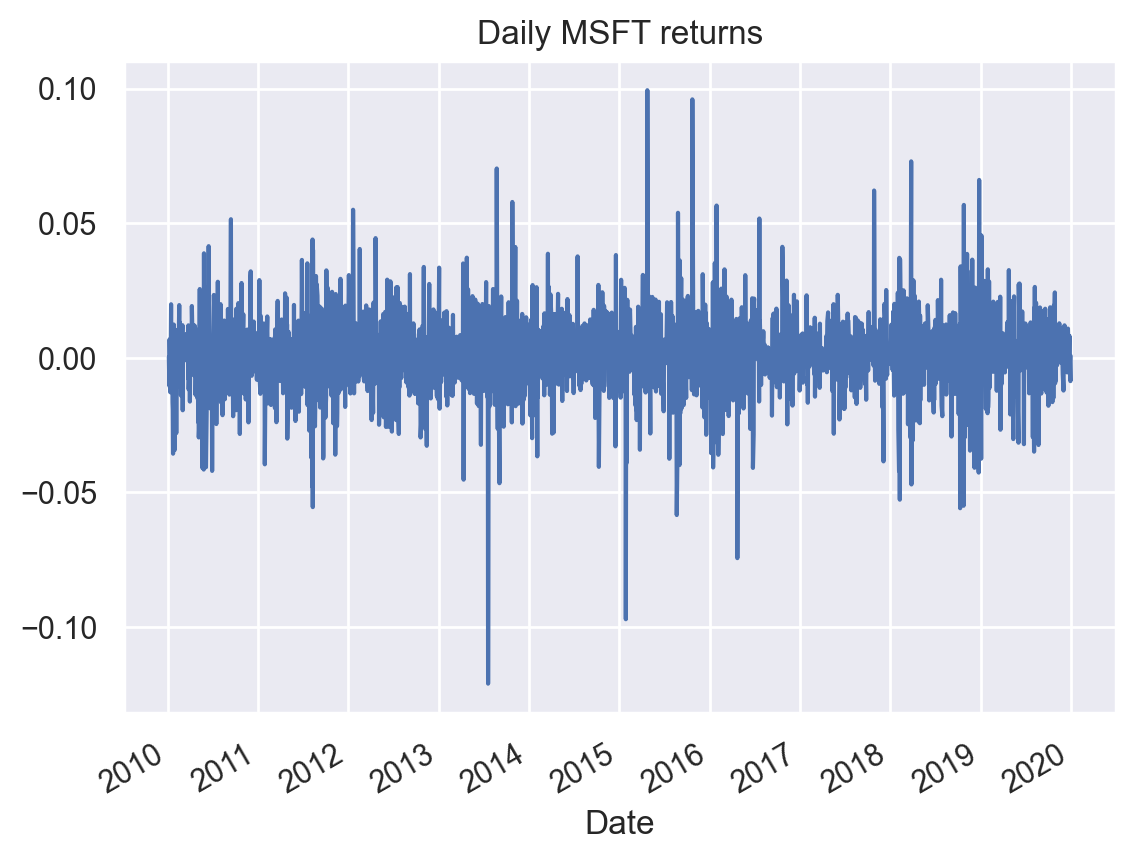

In [32]:
df.log_rtn.plot(title = "Daily MSFT returns")

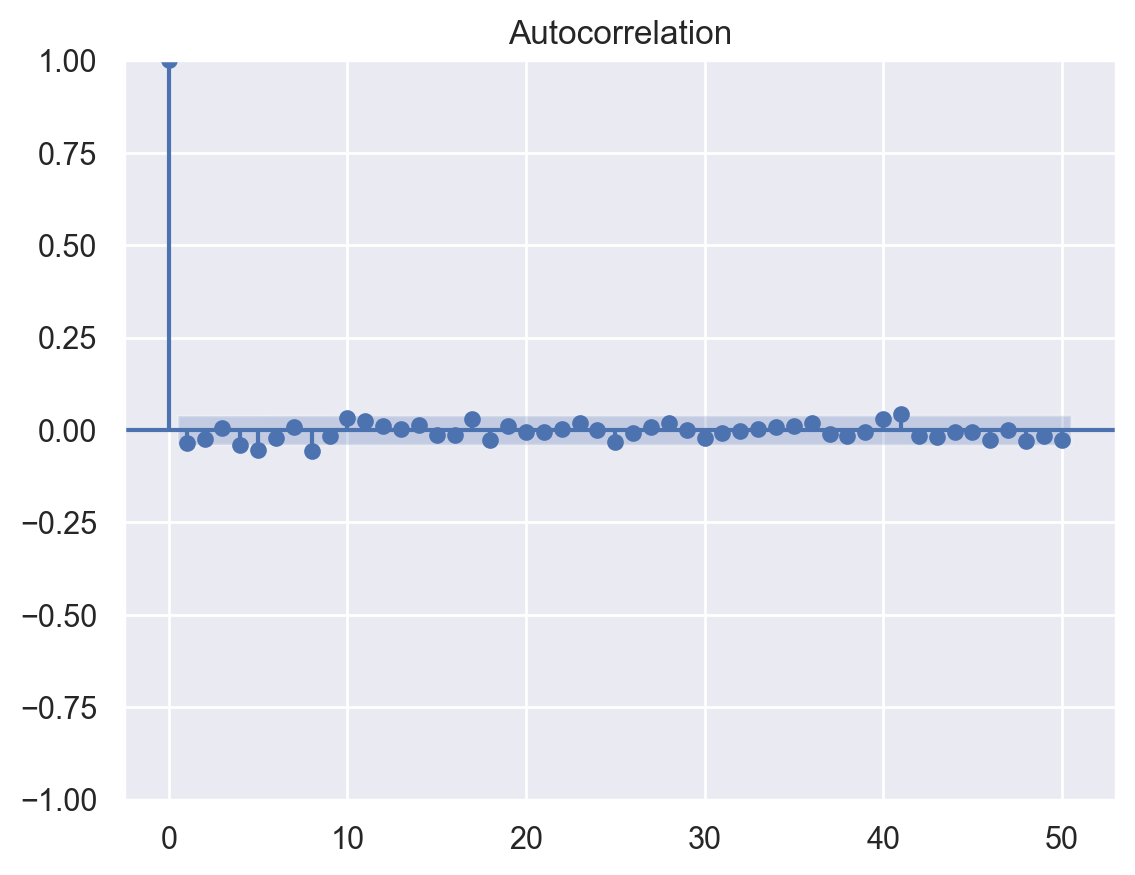

In [37]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

# Remove NaNs to avoid errors
log_rtn_clean = df['log_rtn'].dropna()

# Plot ACF with significance bands
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

acf_plot = smt.graphics.plot_acf(log_rtn_clean,
                                 lags=N_LAGS,
                                 alpha=SIGNIFICANCE_LEVEL)


[Text(0.5, 1.0, 'Absolute Returns'), Text(0.5, 0, 'Lag')]

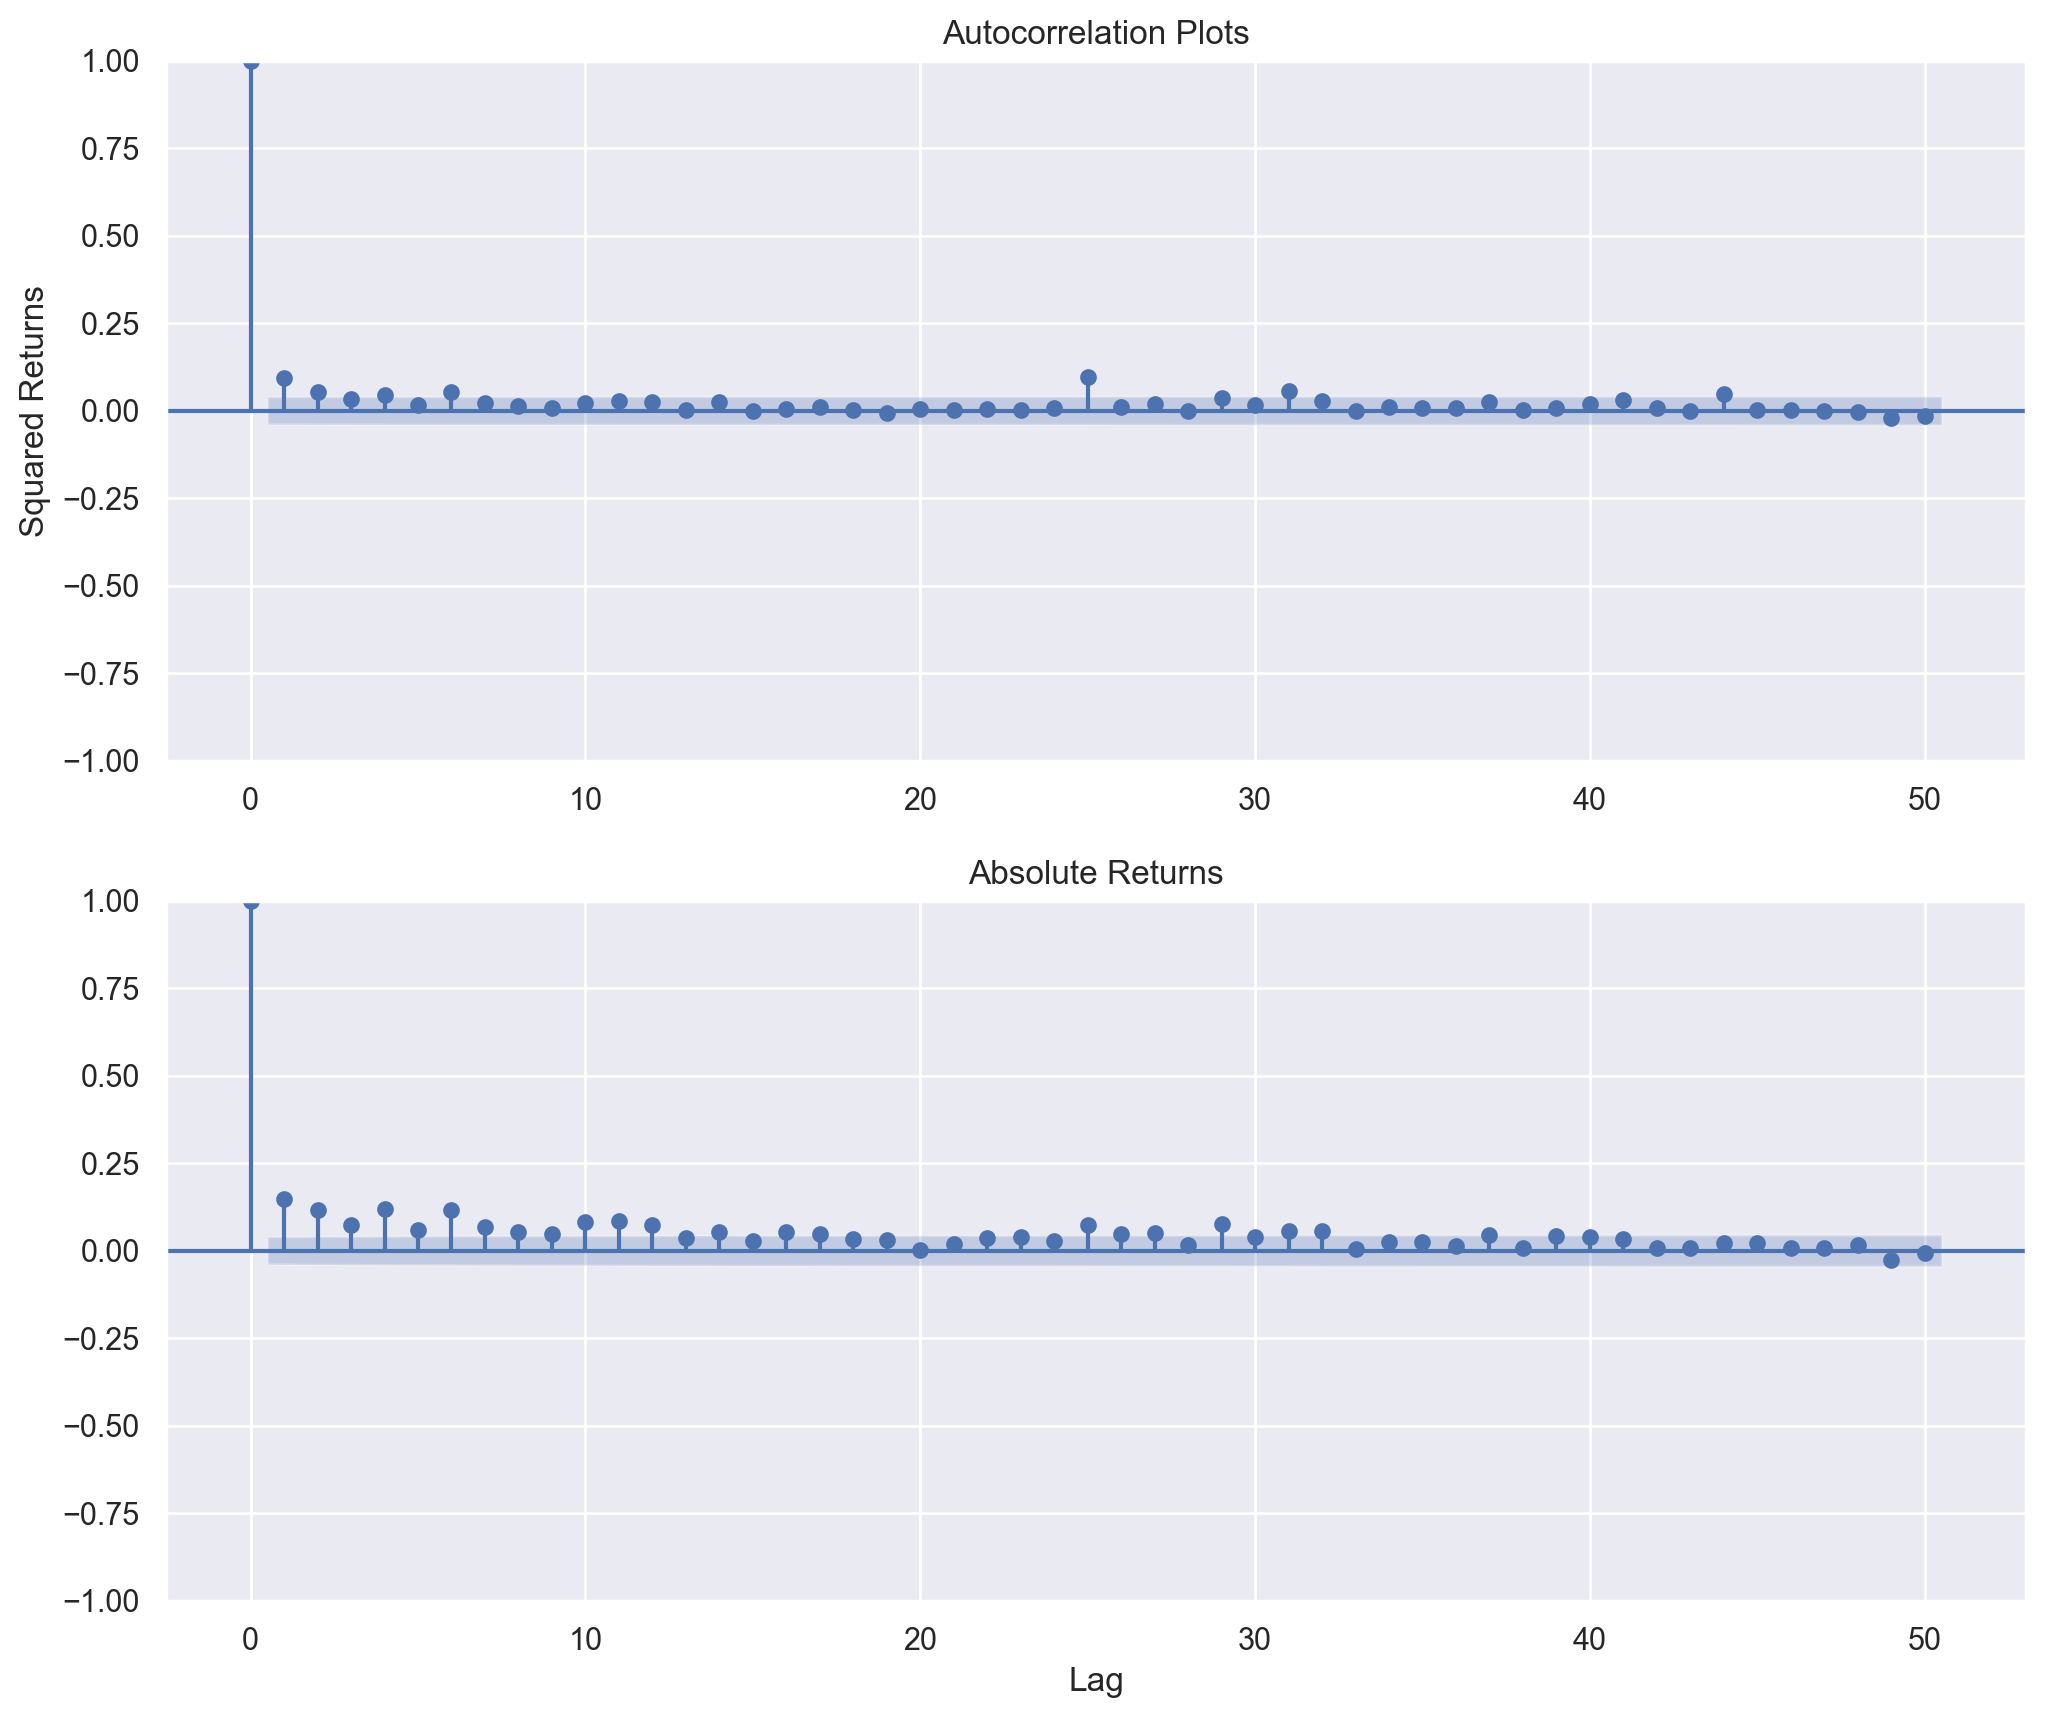

In [40]:
fig, ax = plt.subplots(2, 1, figsize = (12, 10))

smt.graphics.plot_acf(df.log_rtn ** 2, lags = N_LAGS,
                      alpha = SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title = "Autocorrelation Plots",
          ylabel = 'Squared Returns')
smt.graphics.plot_acf(np.abs(df.log_rtn), lags = N_LAGS,
                      alpha = SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(title = "Absolute Returns",
          xlabel = 'Lag')

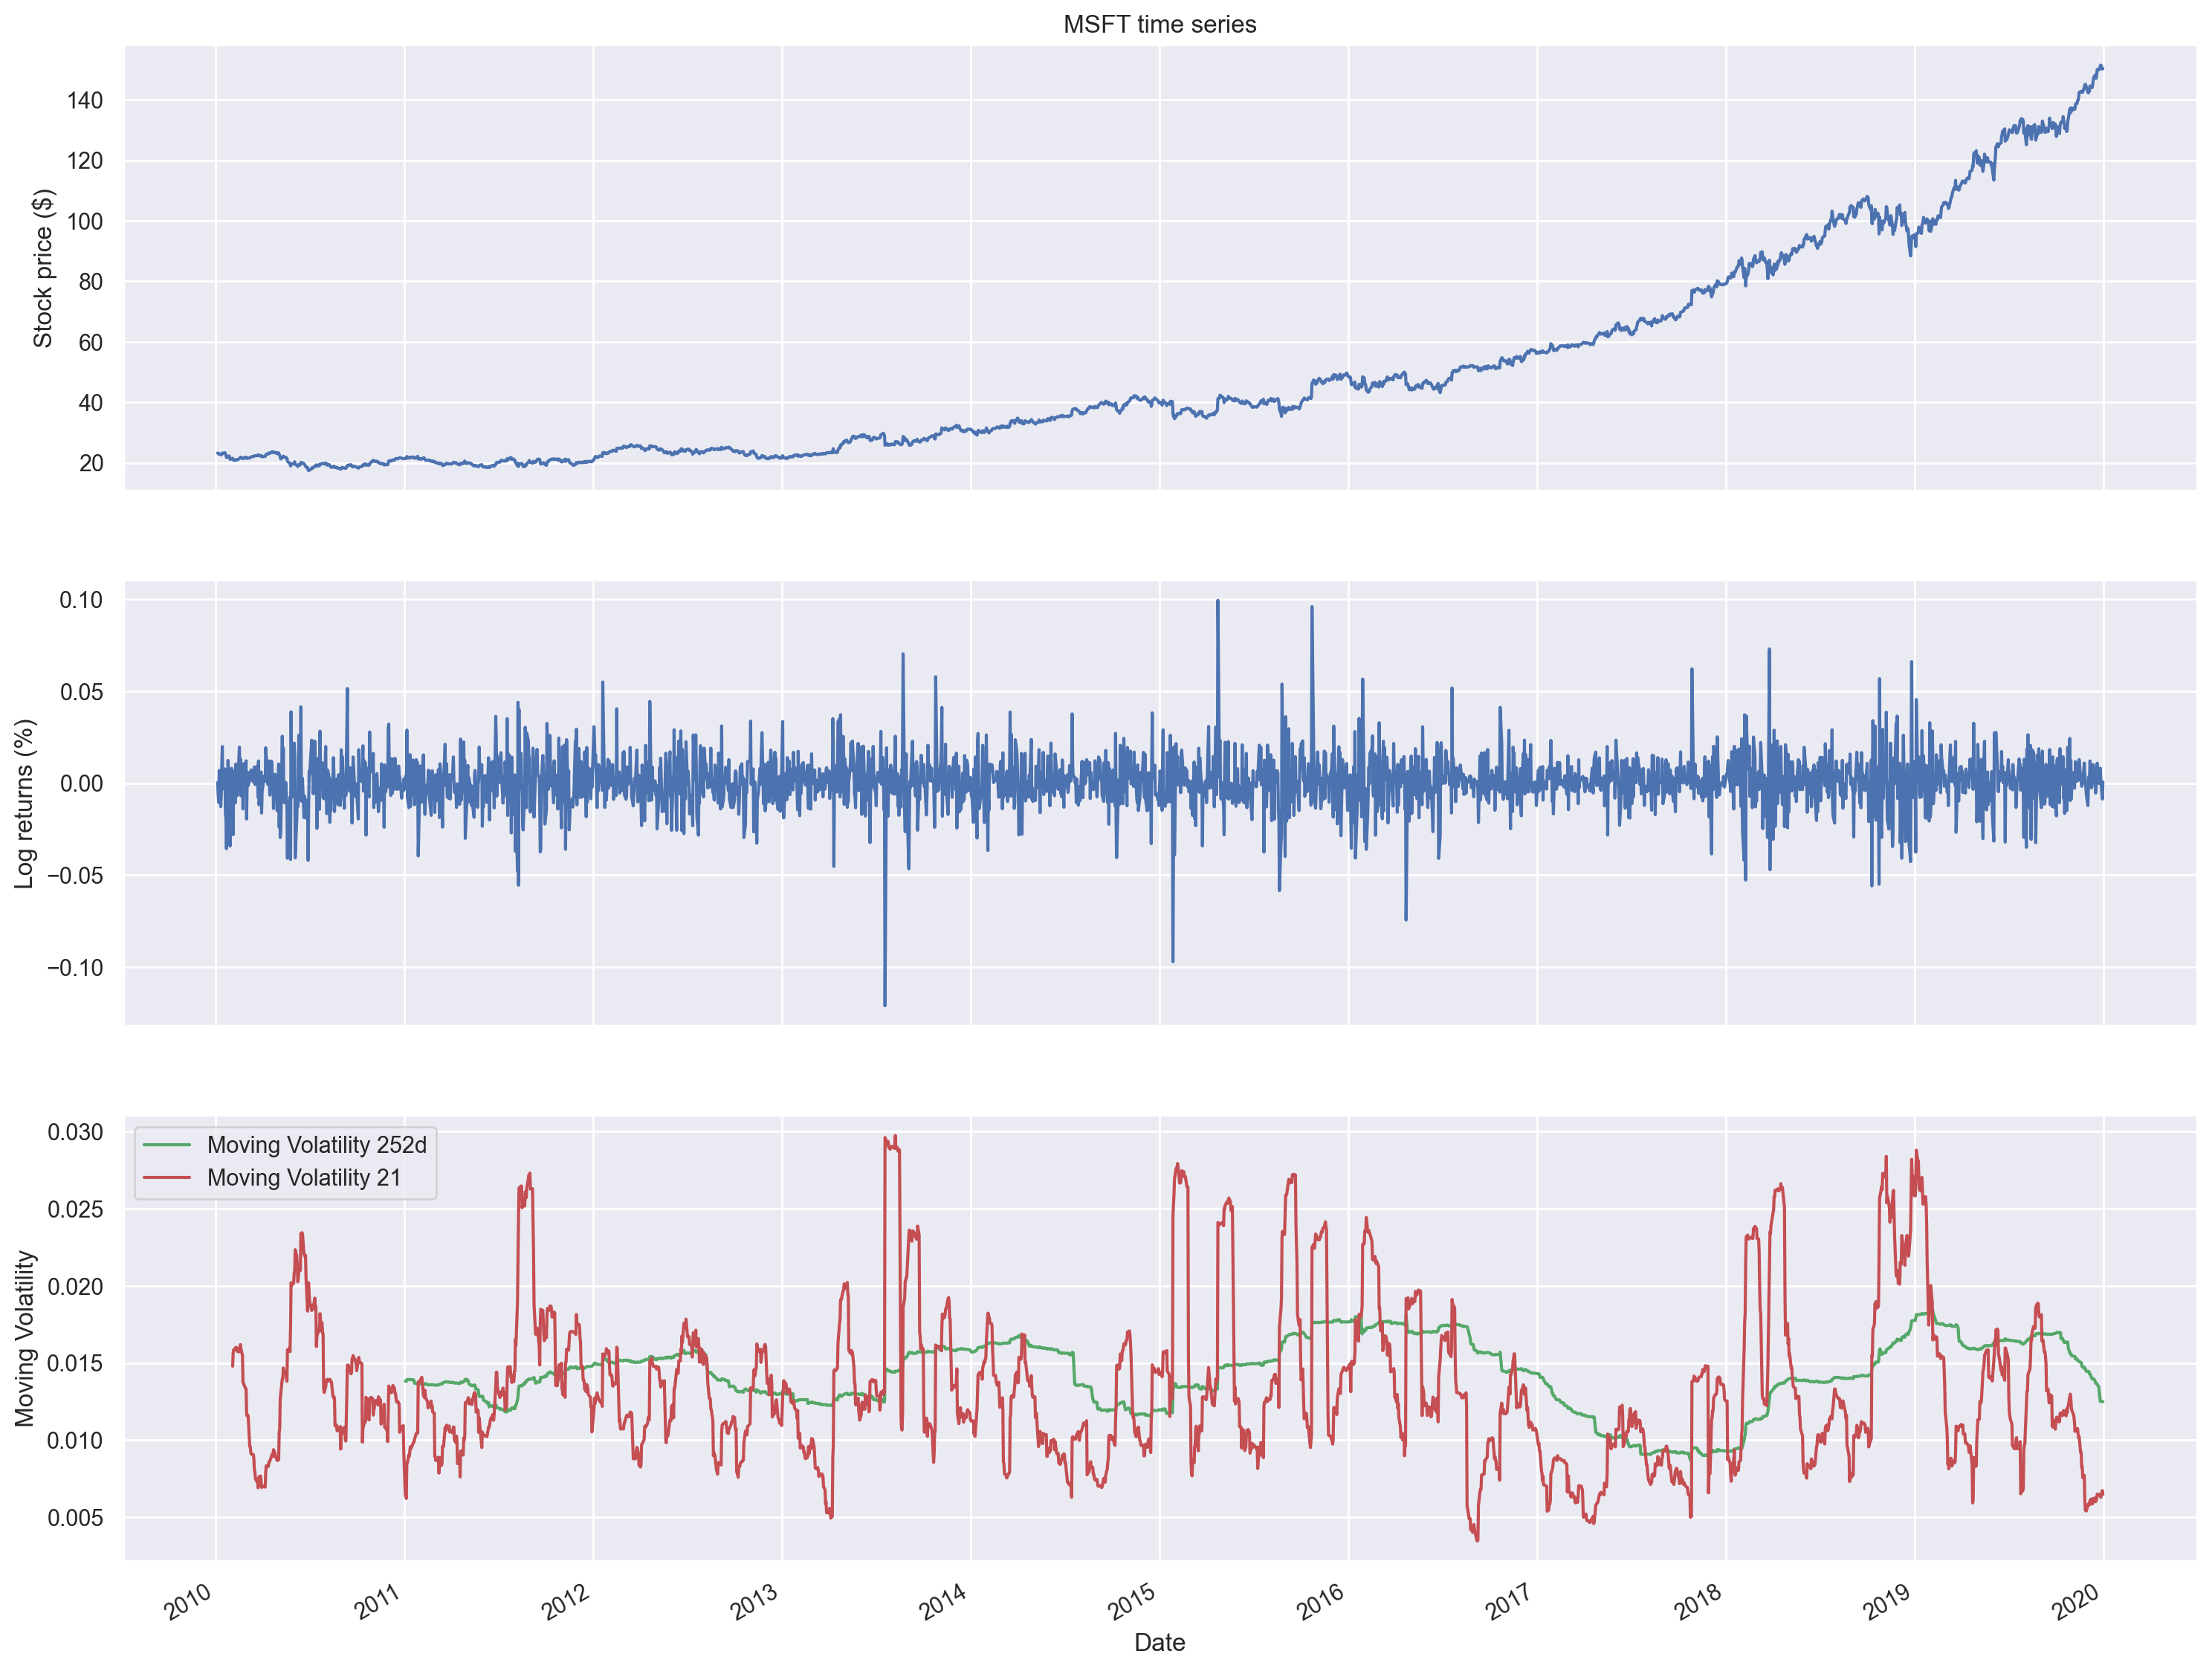

In [44]:
df['moving_std_252'] = df[['log_rtn']].rolling(window = 252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window = 21).std()

fig, ax = plt.subplots(3, 1, figsize = ( 18, 15),sharex = True)

df.adj_close.plot(ax = ax[0])
ax[0].set(title = "MSFT time series",
          ylabel = 'Stock price ($)')
df.log_rtn.plot(ax= ax[1])
ax[1].set(ylabel = 'Log returns (%)')

df.moving_std_252.plot(ax = ax[2] , color = 'g',
                       label = "Moving Volatility 252d")
ax[2].set(ylabel = "Moving Volatility",
          xlabel = "Date")
df.moving_std_21.plot(ax = ax[2], color = 'r',
                      label = "Moving Volatility 21")
ax[2].legend()

In [53]:
df = yf.download(['^GSPC', "^VIX"],
                 start = '1995-01-01',
                 end = '2024-12-31',
                 progress= False)
df = df[['Close']]
df.columns = df.columns.droplevel(0)
df = df.rename(columns = {'^GSPC': 'sp500', "^VIX": "vix"})

/var/folders/32/x9dgly0d26z5yqyvl8t2zw3c0000gn/T/ipykernel_37134/842198291.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True



In [54]:
df

Ticker            sp500        vix
Date                              
1995-01-03   459.109985  14.250000
1995-01-04   460.709991  13.530000
1995-01-05   460.339996  13.500000
1995-01-06   460.679993  13.130000
1995-01-09   460.829987  13.330000
...                 ...        ...
2024-12-23  5974.069824  16.780001
2024-12-24  6040.040039  14.270000
2024-12-26  6037.589844  14.730000
2024-12-27  5970.839844  15.950000
2024-12-30  5906.939941  17.400000

[7551 rows x 2 columns]

In [57]:
df['log_rtn'] = np.log(df['sp500'] / df['sp500'].shift(1))
df['vol_rtn'] = np.log(df['vix'] / df['vix'].shift(1))
df.dropna(how='any', axis=0, inplace=True)


[Text(0.5, 1.0, 'S&P vs. VIX $\\rho$ = -0.72'),
 Text(0, 0.5, 'VIX log returns'),
 Text(0.5, 0, 'S&P log returns')]

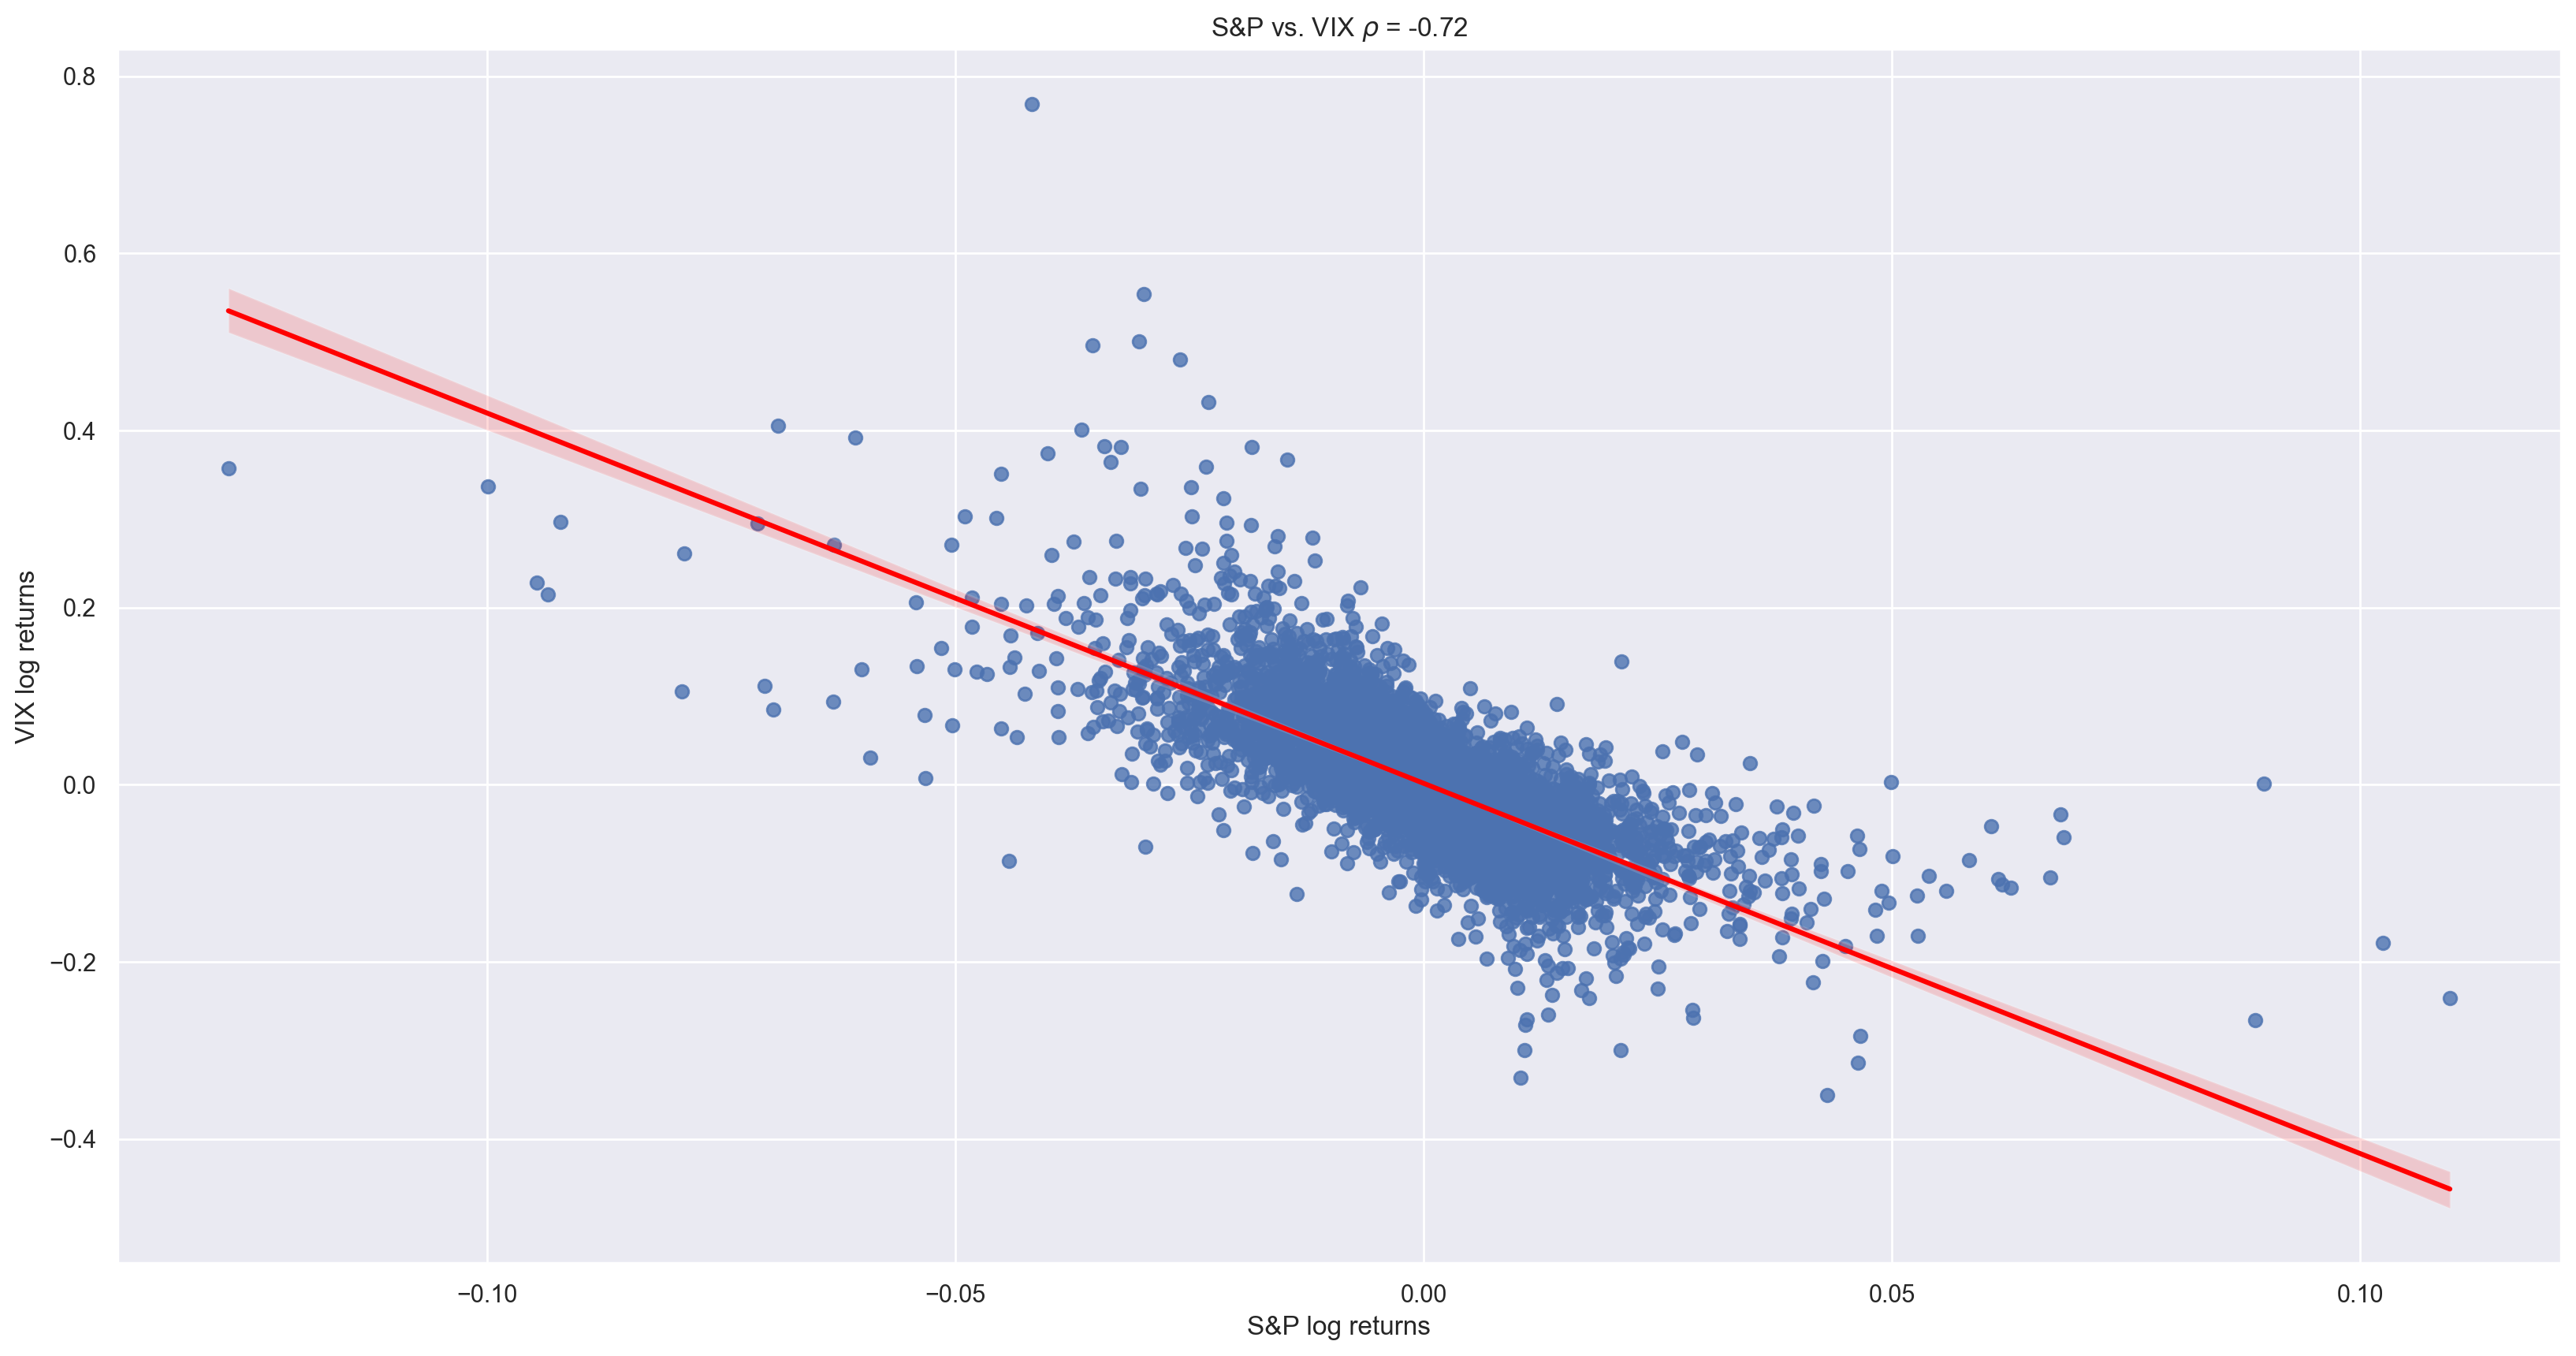

In [68]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)
plt.figure(figsize = (20, 10))
ax = sns.regplot(x = 'log_rtn', y = 'vol_rtn', data = df,
                 line_kws = {'color': 'red'})
ax.set(title = f'S&P vs. VIX $\\rho$ = {corr_coeff:.2f}',
       ylabel = 'VIX log returns',
       xlabel = "S&P log returns")
